In [1]:
import keras

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7532764276207151123
]


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import string
from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout
from keras.models import Model
from string import punctuation

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


In [4]:
def clean_str(tweet):
    """
    Cleaning of dataset
    """
    tweet = re.sub(r"\\", "", tweet)    
    tweet = re.sub(r"\'", "", tweet)    
    tweet = re.sub(r"\"", "", tweet)
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = re.sub(r'˜¥\w*','', tweet)
    tweet = re.sub(r'˜€\w*','', tweet)
    tweet = re.sub(r'˜¤\w*','', tweet)
    tweet = re.sub(r'˜ªðÿ\w*','', tweet)
    tweet = re.sub(r'ðÿ™\w*','', tweet)
    tweet = re.sub(r'\\\w*','', tweet)
    tweet = re.sub(r'±\w*','', tweet)
    tweet = re.sub(r'\w*','', tweet)
    tweet = re.sub(r'™„˜­\w*','', tweet)
    tweet = re.sub(r'ðÿ§€\w*','', tweet)
    tweet = re.sub(r'‘šðÿ¼\w*','', tweet)
    tweet = re.sub(r'ðÿ•\w*','', tweet)
    tweet = re.sub(r'€¢\w*','', tweet)
    tweet = re.sub(r'ã©\w*','', tweet) 
    tweet = re.sub(r'\w*','',tweet)
    #tweet = re.sub(r'ðŸ\x8\w','',tweet)
    return tweet.strip().lower()

In [5]:
data_train = pd.read_excel(r'C:\Users\kushal\Desktop\bennet dataset\Task 5 data\2018-E-c-En-train\2018-E-c-En-train.xlsx')

#data_train["label"] = data_train["Intensity Class"].apply(lambda x : x.split(":")[0])
#data_train = data_train["Tweet"].apply(clean_str)
data_train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,â€œWorry is a down payment on a problem you ma...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [6]:
# Input Data preprocessing
data_train = pd.read_excel(r'C:\Users\kushal\Desktop\bennet dataset\Task 5 data\2018-E-c-En-train\2018-E-c-En-train.xlsx')
#data_train["label"] = data_train["Intensity Class"].apply(lambda x : x.split(":")[0])
data_train["Text"] = data_train["Tweet"].apply(clean_str)
#data_train['label'] = data_train['label'].replace('FAKE',1)
#data_train['label'] = data_train['label'].replace('REAL',0)
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
#labels = []

for i in range(data_train.Text.shape[0]):
    #text1 = data_train.Tweet[i]
    text2 = data_train.Text[i]
    #text = str(text1) +""+ str(text2)
    texts.append(text2)
    #labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Index(['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust',
       'Text'],
      dtype='object')
What the raw input data looks like:
              ID                                              Tweet  anger  \
0  2017-En-21441  â€œWorry is a down payment on a problem you ma...      0   
1  2017-En-31535  Whatever you decide to do make sure it makes y...      0   
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...      1   
3  2017-En-31436  Accept the challenges so that you can literall...      0   
4  2017-En-22195  My roommate: it's okay that we can't spell bec...      1   

   anticipation  disgust  fear  joy  love  optimism  pessimism  sadness  \
0             1        0     0    0     0         1          0        0   
1             0        0     0    1     1         1          0        0   
2             0        1     0    1     0         1          0        0   
3           

In [7]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#labels = to_categorical(np.asarray(labels),num_classes = 0)
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6838, 1000)


In [24]:
labels=  data_train[['anger', 'anticipation', 'disgust', 'fear', 'joy',
       'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]

In [25]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test: ')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 5470 3419 3419
real & fake news in train,valt,test: 
anger           2037
anticipation     778
disgust         2086
fear             959
joy             1970
love             564
optimism        1584
pessimism        629
sadness         1584
surprise         285
trust            286
dtype: int64
anger           1241
anticipation     490
disgust         1273
fear             664
joy             1245
love             350
optimism         981
pessimism        401
sadness         1028
surprise         188
trust            170
dtype: int64
anger           1303
anticipation     488
disgust         1329
fear             578
joy             1232
love             350
optimism        1003
pessimism        394
sadness          980
surprise         173
trust            187
dtype: int64


In [26]:
#Using Pre-trained word embeddings 
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, r'C:\Users\kushal\Desktop\bennet dataset\glove6b100dtxt\glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


W0715 12:41:52.920358 16088 deprecation_wrapper.py:119] From C:\Users\kushal\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Total 400000 word vectors in Glove.


In [28]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(11, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)


W0715 13:18:47.571278 16088 deprecation.py:323] From C:\Users\kushal\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Fitting the simple convolutional neural network model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         1119500   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)     

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


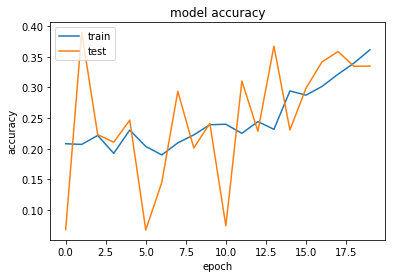

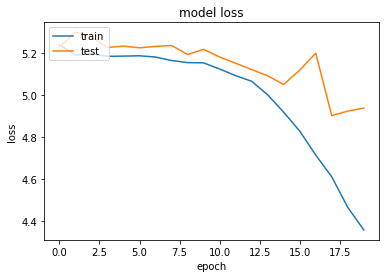

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

C:\Users\kushal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Correct predictions: 2135.0
Total number of test examples: 3419
Accuracy of model1:  0.624451594033343


C:\Users\kushal\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Text(0.5, 0, 'predicted label')

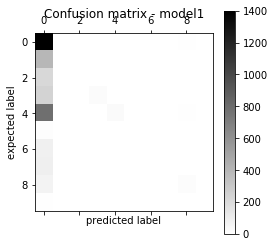

In [41]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test.as_matrix())[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.as_matrix().argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
#test_preds2 = model2.predict(x_test)
#test_preds2 = np.round(test_preds2)
#correct_predictions = float(sum(test_preds2 == y_test)[0])
#print("Correct predictions:", correct_predictions)
#print("Total number of test examples:", len(y_test))
#print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
#x_pred = model2.predict(x_test)
#x_pred = np.round(x_pred)
#x_pred = x_pred.argmax(1)
#y_test_s = y_test.argmax(1)
#m = confusion_matrix(y_test_s, x_pred)
#plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
#plt.title('Confusion matrix - model2')
#plt.colorbar()
#plt.ylabel('expected label')
#plt.xlabel('predicted label')
#plt.show()
